# Libraries :

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from google.cloud import bigquery
from google.oauth2 import service_account

#  Google Cloud BigQuery Authentication

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/home/sinatavakoli284/energy-forecast-pipeline/authentication/gcp-sa-key.json"

credentials = service_account.Credentials.from_service_account_file(
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'],
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

client = bigquery.Client(credentials=credentials)

# Load Data from BigQuery

In [3]:
query = '''
    SELECT * 
    FROM `energy-forecast-pipeline.mart.daily_load_summary`
    WHERE avg_actual_load IS NOT NULL
'''
df = client.query(query).result().to_dataframe()

# Data Preprocessing

In [4]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
df = df.sort_values('date').dropna(subset=['avg_actual_load'])
df.rename(columns={'date': 'ds', 'avg_actual_load': 'y'}, inplace=True)

# Optional: Normalize regressors
df['solar'] = df['total_solar_generation'] / df['total_solar_generation'].max()
df['wind'] = df['total_wind_generation'] / df['total_wind_generation'].max()

# Define Prophet Model with Regressors

In [5]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.1,
    seasonality_mode='multiplicative',
    interval_width=0.9
)

# Add external regressors
model.add_regressor('solar')
model.add_regressor('wind')

# Fill NaNs in regressors to avoid Prophet error
for col in ['solar', 'wind']:
    df[col] = df[col].fillna(df[col].mean())

model.fit(df[['ds', 'y', 'solar', 'wind']])

06:42:52 - cmdstanpy - INFO - Chain [1] start processing
06:42:52 - cmdstanpy - INFO - Chain [1] done processing


# Forecast Future Values

In [6]:
future = model.make_future_dataframe(periods=360)
future['ds'] = pd.to_datetime(future['ds'])
df['ds'] = pd.to_datetime(df['ds'])

future = future.merge(df[['ds', 'solar', 'wind']], on='ds', how='left')

# Fill missing regressors with recent average (simple imputation)
for col in ['solar', 'wind']:
    future[col] = future[col].fillna(df[col].mean())

forecast = model.predict(future)

# Save Forecast

In [7]:
forecast.to_csv("energy_forecast.csv", index=False)

# Visualization: Forecast + Actual

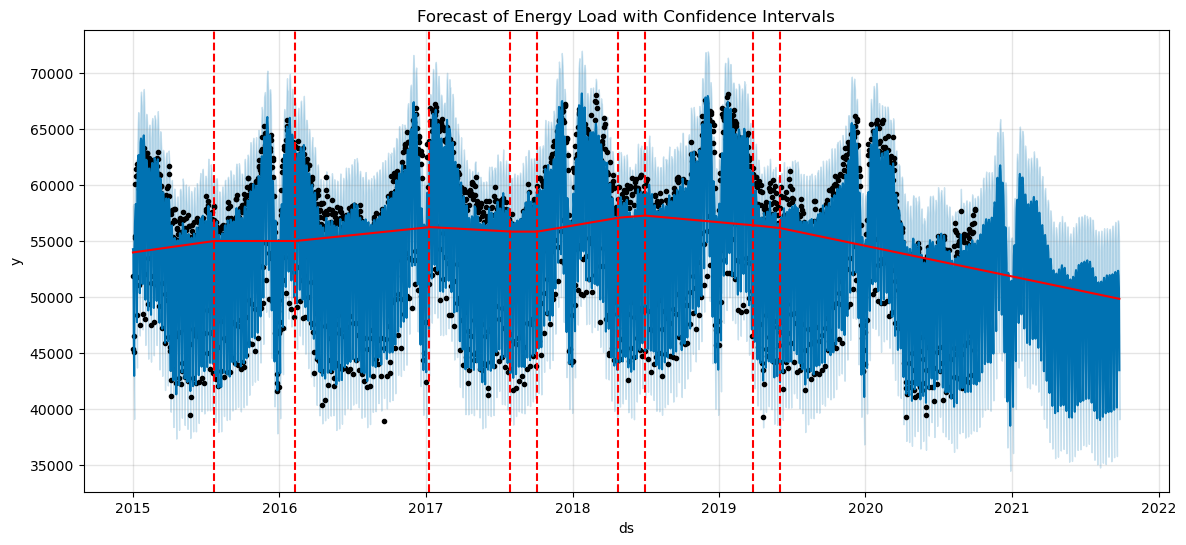

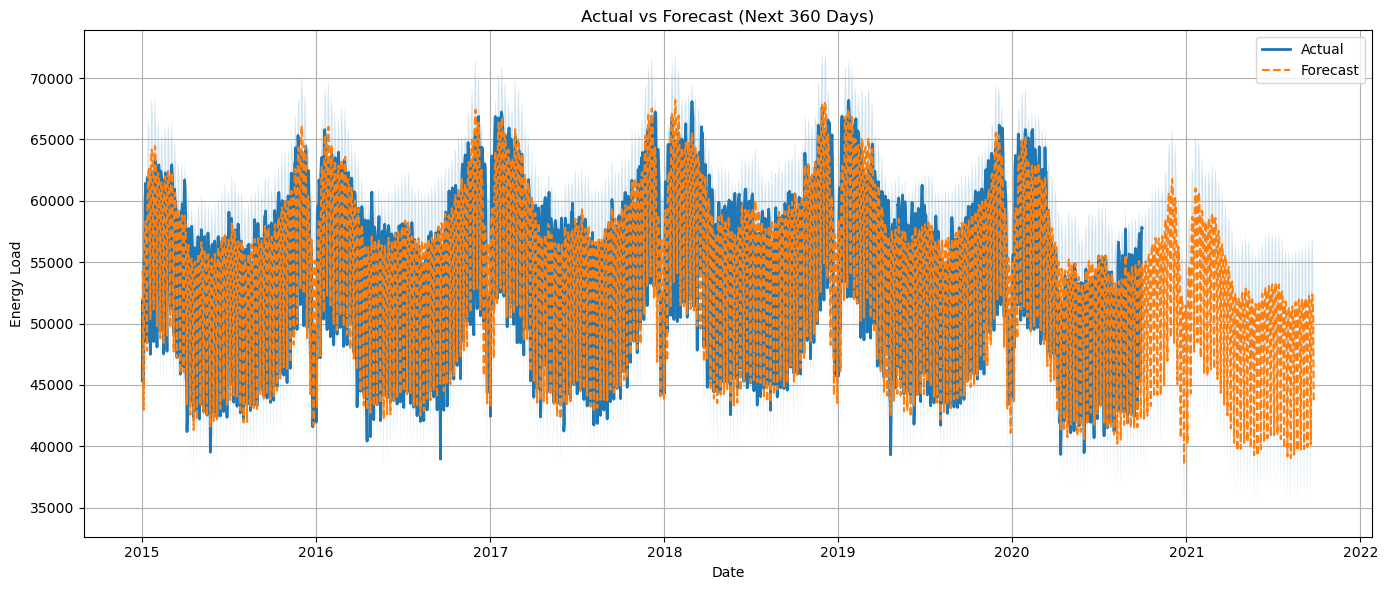

In [8]:
fig, ax = plt.subplots(figsize=(14, 6))
model.plot(forecast, ax=ax)
add_changepoints_to_plot(ax, model, forecast)
plt.title("Forecast of Energy Load with Confidence Intervals")

# Custom Actual vs. Forecast overlay
plt.figure(figsize=(14, 6))
plt.plot(df['ds'], df['y'], label='Actual', linewidth=2)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)
plt.legend()
plt.title("Actual vs Forecast (Next 360 Days)")
plt.xlabel("Date")
plt.ylabel("Energy Load")
plt.grid(True)
plt.tight_layout()
plt.show()